In [1]:
!git clone https://github.com/elenanespolo/Sentiment_Sarcasm_Analysis

%cd Sentiment_Sarcasm_Analysis
!git pull

Cloning into 'Sentiment_Sarcasm_Analysis'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 329 (delta 37), reused 45 (delta 19), pack-reused 255 (from 1)
Receiving objects: 100% (329/329), 20.03 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Filtering content: 100% (11/11), 27.24 MiB | 14.51 MiB/s, done.
/content/Sentiment_Sarcasm_Analysis
Already up to date.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import transformers
import tqdm
from transformers import BertConfig, BertModel, BertTokenizer
from transformers.models.bert.modeling_bert import BertLayer, BertEncoder
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions

pcgrad_repo = "./pcgrad_repo"
if not os.path.exists('./pcgrad_repo'):
    !git clone https://github.com/WeiChengTseng/Pytorch-PCGrad
    !mv Pytorch-PCGrad pcgrad_repo
from pcgrad_repo.pcgrad import PCGrad

!pip install bitsandbytes
# quantization dependency (may need other dependencies that i forgot)

from peft import LoraConfig, get_peft_model, TaskType # LoRA imports (may need to add the pip install)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.8 MB/s eta 0:00:00


# Set parameters

In [6]:
ENABLE_WANDB = True
training_dataset_name = 'twitter'  # 'BESSTIE' or 'yelp' or 'bicodemix' or 'twitter'

use_decoder = False  # if True use decoder otherwise use classification head on top of encoder

use_spAtten = True # if True ...

#NOTE: sentiment always first in 'task' field (index 0), sarcasm second (index 1) where not in dictionary
#NOTE: task always lowercase, but check is always done
#NOTE: class '0' (negative) always first in classes list (index 0), class '1' (positive) second (index 1), etc.
#NOTE: if a task is not present, its classes list is empty (lenght of 0 not None)
#NOTE: BESSTIE dataset apply filter base on value of 'task', 'variety' and 'source' fields,
# if None, no filter applied for that field, only sample with correct values for that field are kept
# if task is 'sentiment' only sample with at least sentiment labels are kept,
# if 'sarcasm', only samples with at least sarcasm labels are kept
# EXAMPLE: task = 'sentiment', variety = 'en-IN', source = 'Reddit' means:
# keep only samples with sentiment labels not nan, variety 'en-IN' and source 'Reddit'

#TODO: check yelp dataset if compatible
#TODO: implement outomatic way to set min_length and max_length based on dataset statistics
#TODO: implement for bicodemix selection of task other than sarcasm-sentiment
train_dataset_CFGs = {
    'BESSTIE':{
        'dataset_name': 'BESSTIE',
        'root_folder': './dataset/besstie',
        'file_name': 'train_SS_with_nan.csv',
        'classes': {
            'sentiment': ['0', '1'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sentiment',
        'variety': 'en-IN',
        'source': 'Reddit',
    },
    'yelp': {
        'dataset_name': 'yelp',
        'root_folder': './dataset/yelp',
        'file_name': 'yelp_filtered_reviews.csv',
        'classes': {
            'sentiment': ['useful', 'funny', 'cool'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    },
    'bicodemix': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': ['0', '1', '2'],
            'sarcasm': ['0', '1'],
        },
        'task': 'sarcasm-sentiment',
    },
    'bicodemix_sarcasm': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': [],
            'sarcasm': ['0', '1'],
        },
        'task': 'sarcasm',
    },
    'bicodemix_sentiment': {
        'dataset_name': 'bicodemix',
        'root_folder': './dataset/bicodemix',
        'file_name': 'train_SS.csv',
        'classes': {
            'sentiment': ['0', '1', '2'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    },
    'twitter': {
        'dataset_name': 'twitter',
        'root_folder': './dataset/twitter',
        'file_name': 'twitter_sentiment_analysis.csv',
        'classes': {
            'sentiment': ['Negative', 'Positive'],
            'sarcasm': [],
        },
        'task': 'sentiment',
    }
}

valid_dataset_CFG = {
    'dataset_name': 'BESSTIE',
    'root_folder': './dataset/besstie',
    'file_name': 'valid_SS_with_nan.csv',
    'classes': {
        'sentiment': ['0', '1'],
        'sarcasm': ['0', '1'],
    },
    'task': train_dataset_CFGs[training_dataset_name]['task'],
    'variety': None,
    'source': None,
}

# TODO: validate parameters
QUANTIZATION_CFG = {
    'load_in_4bit': True,
    'bnb_4bit_quant_type': "nf4",
    'bnb_4bit_compute_dtype': torch.float16,
}

# TODO: validate parameters
LORA_CFG = {
    'r': 16,
    'lora_alpha': 32,
    'target_modules': ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    'lora_dropout': 0.1,
    'bias': "none",
    'task_type': TaskType.CAUSAL_LM
}

CFG = {
    'lr': 2e-5,
    'start_epoch': 0,
    'epochs': 5,
    'batch_size': 8,
    'max_length': 200,
    'min_length': 40,
    "train_dataset_CFG": train_dataset_CFGs[training_dataset_name],
    "valid_dataset_CFG": valid_dataset_CFG,
    'model_name': 'bert-base-uncased',
    'classification_head': 'linear', # ['linear', 'conv', 'lstm', 'multi_task_conv', 'cross_talk_conv']
    'quantization_config': QUANTIZATION_CFG,
    'lora_config': LORA_CFG,
    'seed': 0,
}

IS_MULTITASK = 'sentiment' in CFG['train_dataset_CFG']['task'].lower() and 'sarcasm' in CFG['train_dataset_CFG']['task'].lower()

if IS_MULTITASK:
    print("Training in multitask mode.")
    if CFG['classification_head'] in ['linear', 'conv', 'lstm']:
        print(f"Using {CFG['classification_head']} classification head (single task head) for multi-task learning. Aborting...")
        exit(1)
else:
    print("Training in single task mode.")
    if CFG['classification_head'] in ['multi_task_conv', 'cross_talk_conv']:
        print(f"Using {CFG['classification_head']} classification head (multi-task head) for single task learning. Aborting...")
        exit(1)

print(f"Training with min_length={CFG['min_length']} and max_length={CFG['max_length']}")

quantization_config = transformers.BitsAndBytesConfig(
    **CFG['quantization_config']
)

lora_config = LoraConfig(
    **CFG['lora_config']
)

print("Quantization and LoRA configurations set.")

# for wandb
run_name = f"{training_dataset_name}_{CFG['classification_head']}_spatten"
print(f"Run name is: {run_name}")

Training in single task mode.
Training with min_length=40 and max_length=200
Quantization and LoRA configurations set.
Run name is: twitter_linear_spatten


In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG['seed'])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


# Datasets

In [9]:
if not os.path.exists(os.path.join(CFG['train_dataset_CFG']['root_folder'], CFG['train_dataset_CFG']['file_name'])):
    raise Exception('Training file not found! Please check the train_dataset_CFG configuration.')

if not os.path.exists("./dataset/besstie/train.csv") or not os.path.exists("./dataset/besstie/valid.csv"):
    print("Downloading BESSTIE dataset...")
    # Login using e.g. `huggingface-cli login` to access this dataset
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/train.csv")
    df.to_csv("./dataset/besstie/train.csv", index=False)
    df = pd.read_csv("hf://datasets/unswnlporg/BESSTIE/valid.csv")
    df.to_csv("./dataset/besstie/valid.csv", index=False)
    print("BESSTIE dataset downloaded.")

In [10]:
def get_dataset(dataset_CFG, minlength, maxlength, tokenizer):
    dataset_name = dataset_CFG['dataset_name'].lower()
    if dataset_name == 'twitter':
        from dataset.twitter.dataset_twitter import TwitterDataSet
        dataset = TwitterDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength
        )
    elif dataset_name == 'besstie':
        from dataset.besstie.dataset_besstie import BesstieDataSet
        dataset = BesstieDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'bicodemix':
        from dataset.bicodemix.dataset_bicodemix import BicodemixDataSet
        dataset = BicodemixDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            minlength=minlength,
            maxlength=maxlength,
        )
    elif dataset_name == 'yelp':
        #TODO: implement Yelp dataset class
        raise Exception("Yelp dataset not yet implemented.")
    else:
        raise Exception(f"Dataset {dataset_name} not recognized.")
    return dataset


# Model

## Encoder

### Back-bone and tokenizer

In [11]:
def get_tokenizer_and_encoder(model_name:str):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)
    return tokenizer, model

### Head

In [12]:
class MultiKernelConvs(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        kernel_sizes=(2, 3, 5),
        dropout=0.1
    ):
        super().__init__()

        self.convs = torch.nn.ModuleList([
            torch.nn.Conv1d(
                in_channels=input_size,
                out_channels=hidden_size//len(kernel_sizes),
                kernel_size=k,
                padding=k // 2
            )
            for k in kernel_sizes
        ])

        self.activation = torch.nn.ReLU()
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(dropout)
        self.flatten = torch.nn.Flatten()

        # self.classifier = torch.nn.Linear(
        #     hidden_size * len(kernel_sizes),
        #     num_labels
        # )

    def forward(self, x):
        # x: (B, H, L)
        conv_outputs = []

        for conv in self.convs:
            h = self.activation(conv(x))      # (B, C, L)
            h = self.pool(h).squeeze(-1)       # (B, C)
            conv_outputs.append(h)

        x = torch.cat(conv_outputs, dim=1)    # (B, C * num_kernels)
        x = self.flatten(self.dropout(x))
        # logits = self.classifier(x)

        return x

class ConvClassificationHead(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_labels=2, linear=True):
        super().__init__()

        if linear:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ), # (B, hidden_size)
                torch.nn.Linear(hidden_size, num_labels)
            )
        else:
            self.conv = torch.nn.Sequential(
                MultiKernelConvs(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    kernel_sizes=(3,),
                ) # (B, hidden_size)
            )

    def forward(self, x):
        return self.conv(x)

class MultiTaskConvHead(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_sentiment_labels: int,
        num_sarcasm_labels: int
    ):
        super().__init__()

        self.sentiment_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sentiment_labels
        )

        self.sarcasm_head = ConvClassificationHead(
            input_size=input_size,
            hidden_size=hidden_size,
            num_labels=num_sarcasm_labels
        )

    def forward(self, sequence_output):
        """
        sequence_output: last_hidden_state from BERT
        shape: (batch, seq_len, hidden_size)
        """
        sentiment_logits = self.sentiment_head(sequence_output)
        sarcasm_logits = self.sarcasm_head(sequence_output)

        return {
            "sentiment": sentiment_logits,
            "sarcasm": sarcasm_logits
        }

class CrossTalkHead(torch.nn.Module):
    def __init__(
        self,
        input_size,
        conv_hidden_size,
        num_sentiment_labels,
        num_sarcasm_labels,
    ):
        super().__init__()

        self.encoder = ConvClassificationHead(
            input_size=input_size,
            hidden_size=conv_hidden_size,
            linear = False
        )

        # task-specific embeddings
        self.sentiment_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_embed = torch.nn.Linear(
            conv_hidden_size, conv_hidden_size
        )

        # cross-talk layers
        self.sentiment_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )
        self.sarcasm_fuse = torch.nn.Linear(
            2 * conv_hidden_size, conv_hidden_size
        )

        self.sentiment_out = torch.nn.Linear(
            # conv_hidden_size, np.max([num_sentiment_labels, num_sarcasm_labels])
            conv_hidden_size, num_sentiment_labels
        )
        self.sarcasm_out = torch.nn.Linear(
            conv_hidden_size, num_sarcasm_labels
        )

    def forward(self, sequence_output):
        shared = self.encoder(sequence_output)

        # first linear layer
        sent_feat = self.sentiment_embed(shared)
        sarc_feat = self.sarcasm_embed(shared)

        # cross-talk
        sent_feat_cross = self.sentiment_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )
        sarc_feat_cross = self.sarcasm_fuse(
            torch.cat([sarc_feat, sent_feat], dim=-1)
        )

        return {
            "sentiment": self.sentiment_out(sent_feat_cross),
            "sarcasm": self.sarcasm_out(sarc_feat_cross)
        }

In [13]:
def get_classification_head(method: str, input_size:int, hidden_size: int, num_labels: int):
    num_sent_labels, num_sarc_labels = num_labels

    # Single task case
    if not IS_MULTITASK:
        num_task_labels = max(num_sent_labels, num_sarc_labels)

    if method == "linear":
        return torch.nn.Linear(input_size, num_task_labels)
    elif method == "conv":
        return ConvClassificationHead(input_size, hidden_size, num_task_labels)
    elif method == "lstm":
        return torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
    elif method == "multi_conv":
        return torch.nn.Sequential(
            MultiKernelConvs(
                input_size=input_size,
                hidden_size=hidden_size,
                kernel_sizes=(2, 3, 5),
                dropout=0.1
            ),
            torch.nn.Linear(hidden_size, num_task_labels)
        )
    elif method == 'multi_task_conv':
        return MultiTaskConvHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    elif method == 'cross_talk_conv':
        return CrossTalkHead(input_size, hidden_size, num_sent_labels, num_sarc_labels)
    else:
        raise ValueError(f"Unknown classification head method: {method}")

### Classifier

In [14]:
class MyClassifier(torch.nn.Module):
    def __init__(self, base_model_name, classification_head_name, num_labels, multitask:bool):
        super().__init__()

        self.multitask = multitask

        num_sent_labels, num_sarc_labels = num_labels

        # Single task case
        if not self.multitask:
            num_task_labels = max(num_sent_labels, num_sarc_labels)

        self.tokenizer, self.base_model = get_tokenizer_and_encoder(base_model_name)
        self.hidden_size = self.base_model.config.hidden_size
        self.dropout = torch.nn.Dropout(self.base_model.config.hidden_dropout_prob)

        self.classification_head_name = classification_head_name

        self.classification_head = get_classification_head(
            classification_head_name, self.hidden_size, self.hidden_size, num_labels
        )

        if classification_head_name == "lstm":
            self.output_layer = torch.nn.Linear(self.hidden_size*2, num_task_labels)

    def get_tokenizer(self) -> transformers.PreTrainedTokenizer:
        return self.tokenizer

    def forward(self, inputs, task=None):
        outputs = self.base_model(**inputs)
        sequence = self.dropout(outputs.last_hidden_state)

        if self.classification_head_name == "linear":
            cls_rep = sequence[:, 0, :]
            logits = self.classification_head(cls_rep)

        elif self.classification_head_name == "conv":
            # x: (batch, seq_len, hidden_size)
            x = sequence.transpose(1, 2)  # -> (batch, hidden_size, seq_len)
            logits = self.classification_head(x)

        elif self.classification_head_name == "lstm":
            #TODO: check if works correctly
            lstm_out, _ = self.classification_head(sequence)
            cls_rep = lstm_out[:, 0, :]
            logits = self.output_layer(cls_rep)

        elif self.classification_head_name == 'multi_conv':
            # TODO: implement
            logits = None

        elif self.classification_head_name == 'multi_task_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        elif self.classification_head_name == 'cross_talk_conv':
            x = sequence.transpose(1, 2)
            logits = self.classification_head(x)

        if self.multitask and task is not None:
            return logits[task]
        else:
            return logits


### SpAtten

#### Utility functions

In [43]:
def topk_masking(scores, keep_ratio, active_mask):
    """
    Create a hard mask by keeping the top-k tokens based on scores.
    Args:
        scores (torch.Tensor): Scores for each token (batch_size, seq_len).
        keep_ratio (float): Ratio of tokens to keep (between 0 and 1).
        mask (torch.Tensor): Original attention mask (batch_size, seq_len) with 1s for valid tokens and 0s for padding.
    Returns:
        torch.Tensor: Hard mask (batch_size, seq_len) with 1s for kept tokens and 0s for pruned tokens.
    """

    new_mask = torch.zeros_like(scores)

    for i, (sample, active_token) in enumerate(zip(scores, active_mask)):
        seq_len = active_token.sum().item()  # number of active tokens in the sample

        k = max(1, int(seq_len * keep_ratio))

        # Get the top-k indices
        topk_indices = torch.topk(sample, k, dim=-1).indices

        # print(f"Sample {i}: keeping top {len(topk_indices)/seq_len*100:.2f} percent tokens")

        # Create a mask initialized to zeros
        mask = torch.zeros_like(sample)

        # Scatter 1s into the mask at the top-k indices
        mask.scatter_(0, topk_indices, 1)

        new_mask[i, active_token.bool()] = mask[active_token.bool()]

    return new_mask

def magnitude_head_scores(attention_output, num_heads, head_mask):
    """
    attention_output: (batch, seq_len, hidden_size)
    returns: (batch, num_heads)
    """
    batch_size, seq_len, hidden_size = attention_output.size()
    head_dim = hidden_size // num_heads

    # E \in (batch, heads, L0, D)
    E = attention_output.view(
        batch_size, seq_len, num_heads, head_dim
    ).permute(0, 2, 1, 3)

    # s_h = sum_{l,d} |E|
    head_scores = E.abs().sum(dim=(2, 3))  # (batch, heads)

    head_scores = head_scores * head_mask # Apply head mask to zero out pruned heads

    # print("Raw head scores (summed magnitudes):", head_scores.cpu().detach()/seq_len)
    return head_scores/seq_len


#### A layer of bert

In [48]:
class CascadingMaskBertLayer(BertLayer):
    def __init__(self, config: BertConfig, prune_token_percent, prune_head_percent, visualize=False):
        super().__init__(config)
        self.prune_token_percent = prune_token_percent
        self.prune_head_percent = prune_head_percent
        self.visualize = visualize

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        token_mask=None,
        head_mask=None,
        output_attentions=True,
        output_hidden_states=False,
    ):

        # print(attention_mask.shape) # Keep for debugging if needed
        if token_mask is None:
            # Fix: Extract (batch_size, sequence_length) from (batch_size, 1, sequence_length, sequence_length)
            token_mask = (attention_mask[:, 0, 0, :] > -1).clone().int()
        print(token_mask.sum(dim=1)) # Keep for debugging if needed

        batch_size = hidden_states.size(0)
        num_heads = self.attention.self.num_attention_heads

        if head_mask is None:
            head_mask = torch.ones(
                (batch_size, num_heads),
                device=hidden_states.device
            )

        head_mask_expanded = head_mask[:, :, None, None]

        # ---- Apply previous cascade ----
        # print(hidden_states.shape)
        # print(token_mask.shape)
        hidden_states = hidden_states * token_mask.unsqueeze(-1)

        # ---- Extend attention mask ----
        cascade_attn_mask = (1.0 - token_mask) * -1e4

        # ---- Self-attention ----
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask+ cascade_attn_mask.unsqueeze(1).unsqueeze(2),
            head_mask=head_mask_expanded,
            output_attentions=output_attentions,
        )
        attention_output, attention_scores = self_attention_outputs

        if self.visualize:
            for sample in range(attention_scores.size(0)):
                if head_mask_expanded[sample,0,0,0] == 0:  # Check if head 0 is active for this sample
                    print(f"Sample {sample} head 0 is pruned, skipping attention score visualization.")
                    continue
                plt.figure()
                plt.title(f"Attention scores for sample {sample} (head 0):")
                sns.heatmap(attention_scores[sample,0,:,:].cpu().detach(), cmap='viridis')
                plt.show()


            plt.figure()
            plt.title(f"Head mask for each sample")
            # sns.heatmap(attention_scores.sum(dim=(2,3)).cpu().detach(), cmap='viridis')
            sns.heatmap(head_mask, cmap='viridis')
            plt.ylabel("Sample index")
            plt.xlabel("Head index")
            plt.show()


        # ---- Compute new token decisions ----
        token_scores = attention_scores.sum(dim=(1,2))  # (batch_size, seq_len)

        new_token_mask = topk_masking(
            token_scores,
            keep_ratio=1-self.prune_token_percent,  # eliminate bottom pt% tokens
            active_mask=attention_mask[:,0,0,:] > -1
        )
        # Protect CLS
        new_token_mask[:, 0] = 1.0

        # ---- CASCADE ----
        token_mask = token_mask * new_token_mask



        # ---- Compute new head decisions ----
        heads_scores = magnitude_head_scores(attention_output, num_heads=num_heads, head_mask=head_mask)

        new_head_mask = topk_masking(
            heads_scores,  # (batch_size, num_heads)
            keep_ratio=1-self.prune_head_percent,
            active_mask=torch.ones_like(heads_scores)
        )

        # ---- CASCADE ----
        head_mask = new_head_mask


        batch_size, seq_len, hidden_size = attention_output.size()
        head_dim = hidden_size // num_heads

        E = attention_output.view(
            batch_size, seq_len, num_heads, head_dim
        ).permute(0, 2, 1, 3)

        E = E * head_mask[:, :, None, None] # Apply head mask to attention output

        attention_output = E.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, hidden_size)

        # ---- Feed-forward ----
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)

        return layer_output, token_mask, head_mask

#### Bert

In [49]:
import seaborn as sns

class CascadingBertEncoder(BertEncoder):
    def __init__(self, config, visualize, visualize_prune_decisions=False):
        super().__init__(config)
        self.layer = torch.nn.ModuleList([
            CascadingMaskBertLayer(config, config.pt[i], config.ph[i], visualize=visualize[i])
            for i in range(config.num_hidden_layers)
        ])
        self.visualize_prune_decisions = visualize_prune_decisions

        self.text_history = [] # Store input texts for visualization

        # for i in range(len(self.bert.encoder.layer)):
        #     self.bert.encoder.layer[i] = CascadingMaskBertLayer(self.bert.config, pt_schedule[i], ph_schedule[i])

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
        **kwargs,
    ):
        self.text_history = []
        batch_size = hidden_states.size(0)
        token_mask = None
        head_mask = None

        for i, layer_module in enumerate(self.layer):
            hidden_states, token_mask, head_mask = layer_module(
                hidden_states,
                attention_mask=attention_mask,
                token_mask=token_mask,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )

            if self.visualize_prune_decisions:
                print(f"Layer {i} active tokens:", token_mask.sum(dim=1))
                print(f"Layer {i} active heads:", head_mask.sum(dim=1))

            self.text_history.append(
                {
                    "layer": i,
                    "active_tokens": token_mask.cpu().detach().numpy(),
                    "active_heads": head_mask.cpu().detach().numpy()
                })

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    None,
                    None,
                    None,
                    None,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=None,
            hidden_states=None,
            attentions=None,
            cross_attentions=None,
        )


#### Top level model
The only difference from previously defined classifier 'MyClassifier' is the overwrtite of 'self.bert.encoder' with a custom class to add the functionalities required.

In [50]:
class MyClassifierSpAtten(torch.nn.Module):
    def __init__(self, config:BertConfig, base_model_name="bert-base-uncased", num_labels=2, visualize_prune_decisions=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(base_model_name, config=config)
        self.tokenizer = BertTokenizer.from_pretrained(base_model_name)

        self.bert.encoder = CascadingBertEncoder(self.bert.config, visualize=[visualize_prune_decisions for _ in range(config.num_hidden_layers)], visualize_prune_decisions=visualize_prune_decisions)

        num = num_labels if isinstance(num_labels, int) else num_labels[0]+num_labels[1]
        self.dense = torch.nn.Linear(config.hidden_size, num)

    def forward(self, inputs, task:str=None):
        bert_outputs = self.bert(**inputs)

        # print("BERT output:", bert_outputs)
        cls_token = bert_outputs.last_hidden_state[:, 0]  # Use [CLS] token representation
        return self.dense(cls_token)

Cascading token pruning schedule: [0.0, 0.09999999999999998, 0.09999999999999998, 0.18999999999999995, 0.18999999999999995, 0.2709999999999999, 0.2709999999999999, 0.3438999999999999, 0.3438999999999999, 0.4095099999999998, 0.4095099999999998, 0.46855899999999984]
Cascading head pruning schedule: [0.0, 0.030000000000000027, 0.030000000000000027, 0.05910000000000004, 0.05910000000000004, 0.08732700000000004, 0.08732700000000004, 0.11470719000000007, 0.11470719000000007, 0.1412659743000001, 0.1412659743000001, 0.16702799507100008]


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tensor([76, 75, 51])


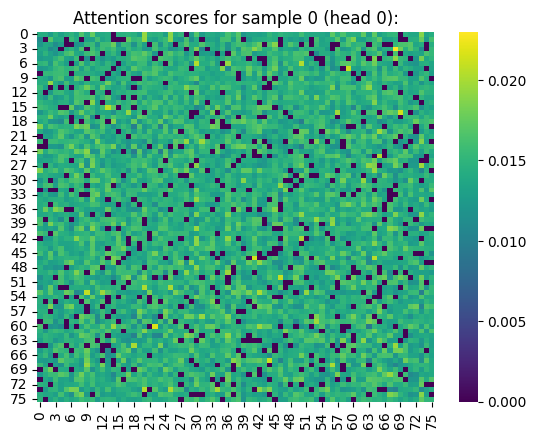

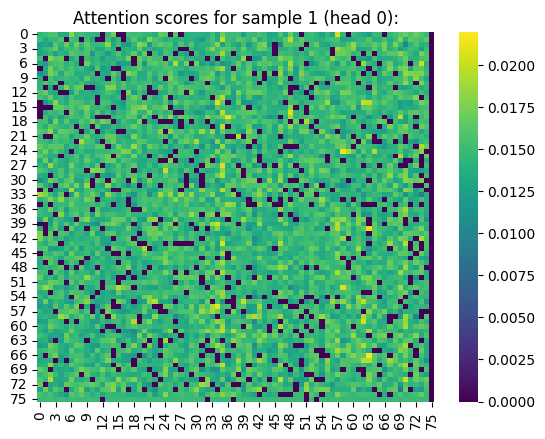

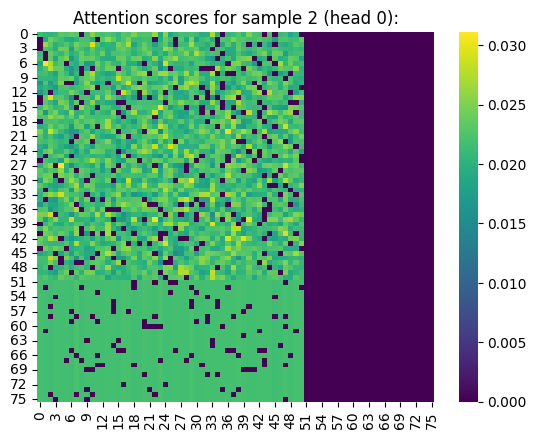

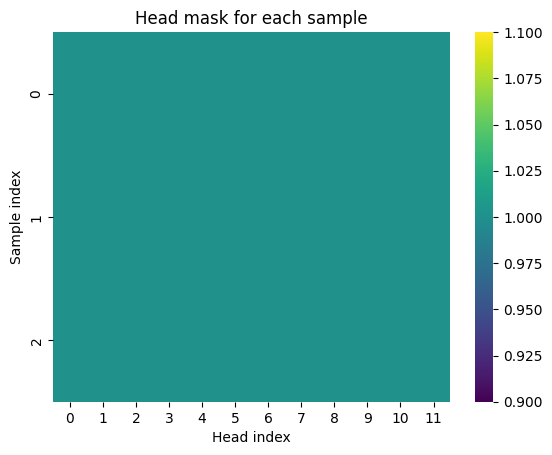

Layer 0 active tokens: tensor([76., 75., 51.])
Layer 0 active heads: tensor([12., 12., 12.])
tensor([76., 75., 51.])


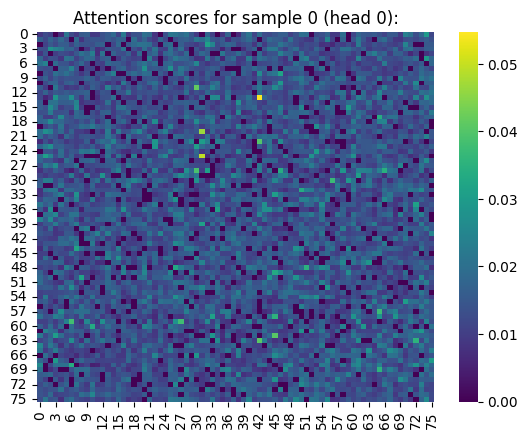

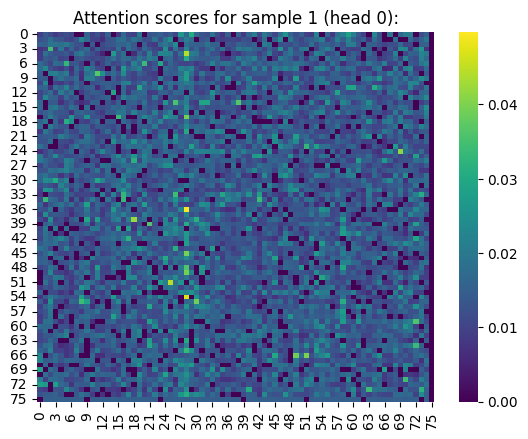

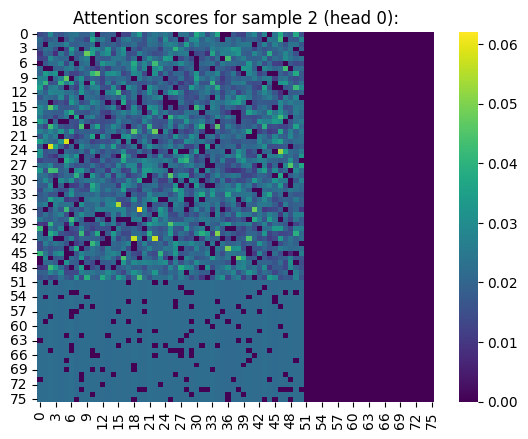

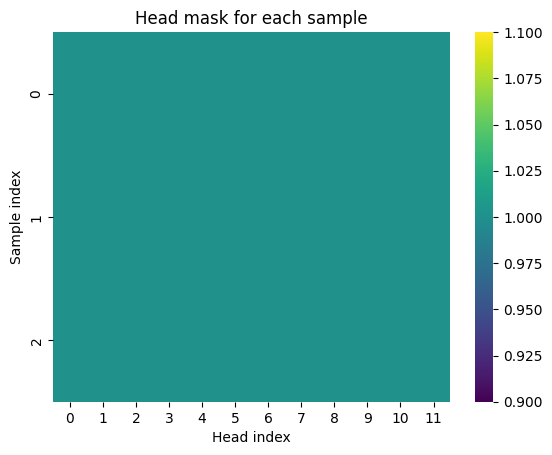

Layer 1 active tokens: tensor([68., 67., 45.])
Layer 1 active heads: tensor([11., 11., 11.])
tensor([68., 67., 45.])


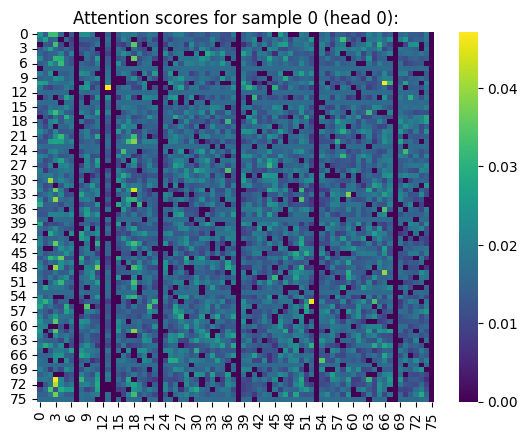

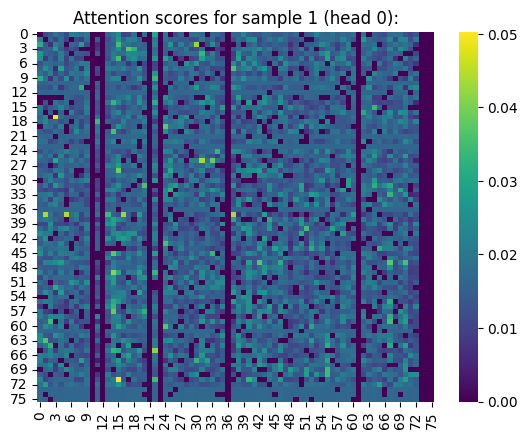

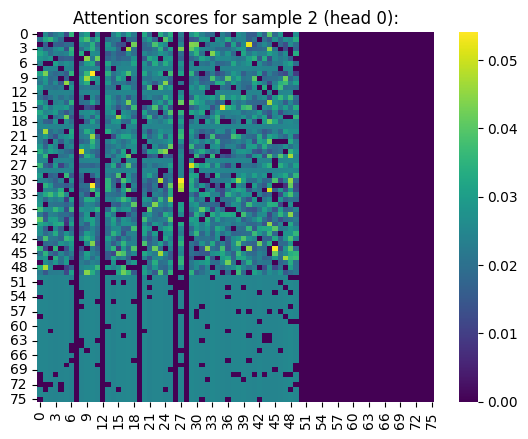

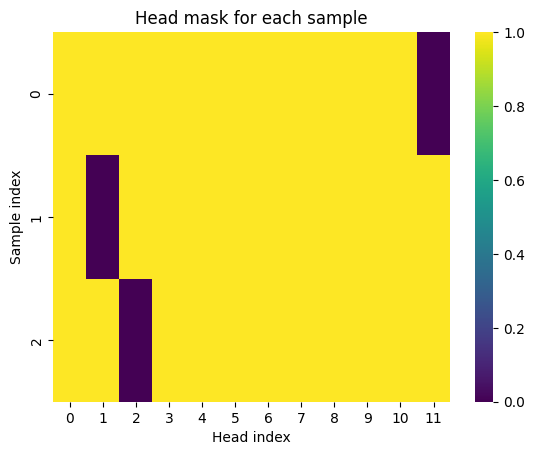

Layer 2 active tokens: tensor([68., 67., 45.])
Layer 2 active heads: tensor([11., 11., 11.])
tensor([68., 67., 45.])


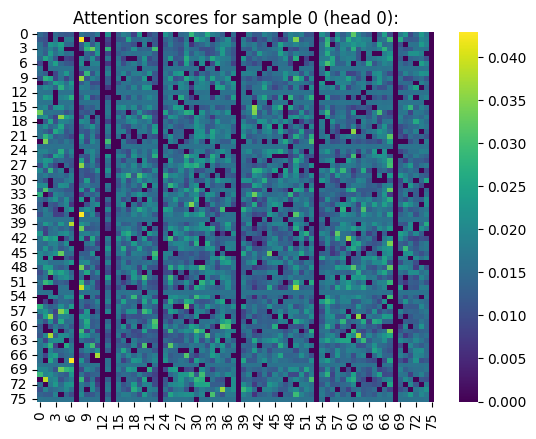

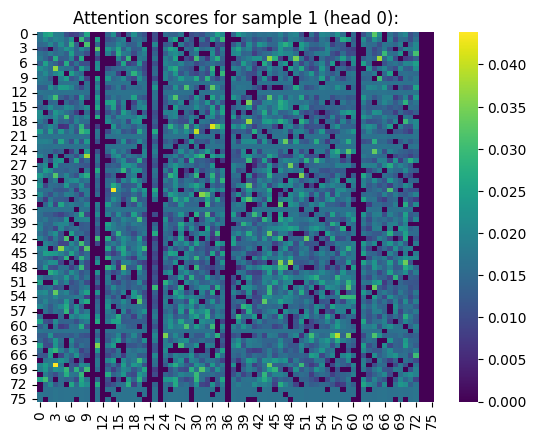

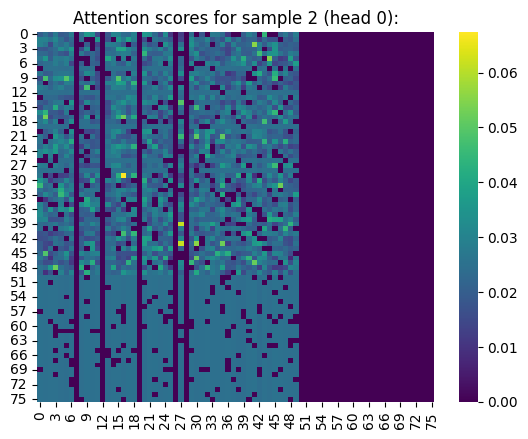

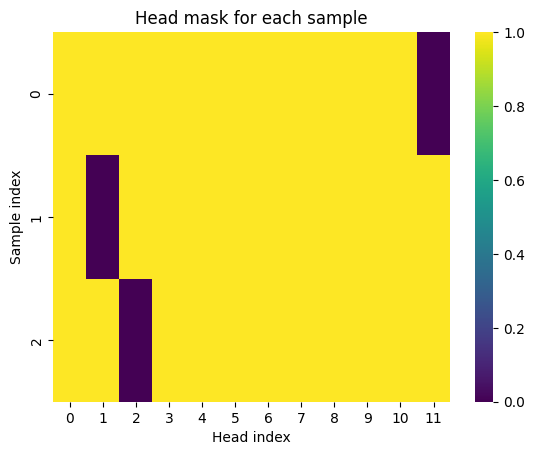

Layer 3 active tokens: tensor([61., 60., 41.])
Layer 3 active heads: tensor([11., 11., 11.])
tensor([61., 60., 41.])


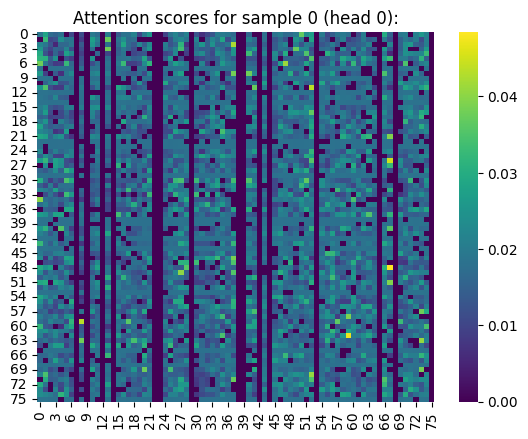

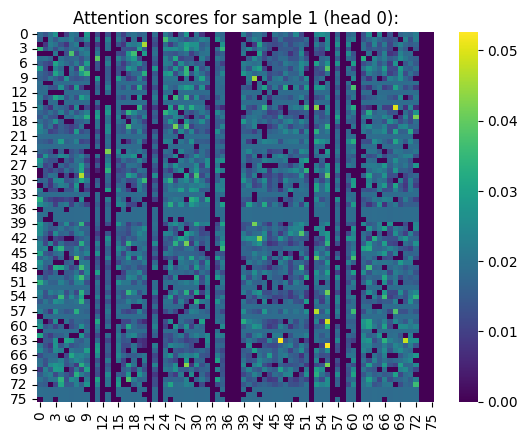

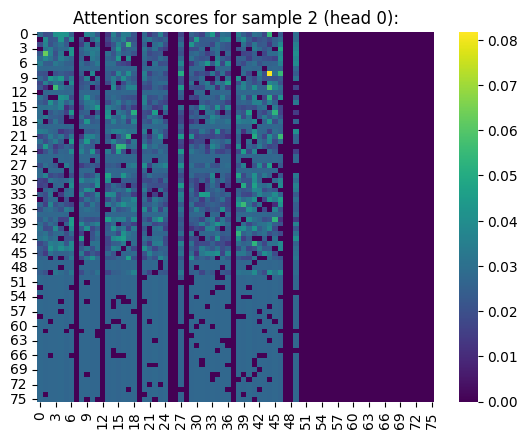

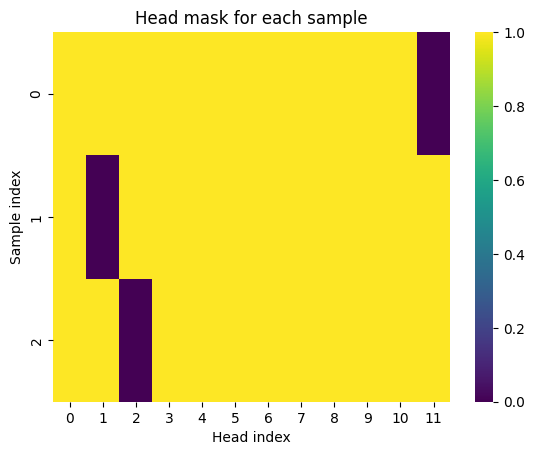

Layer 4 active tokens: tensor([61., 60., 41.])
Layer 4 active heads: tensor([11., 11., 11.])
tensor([61., 60., 41.])


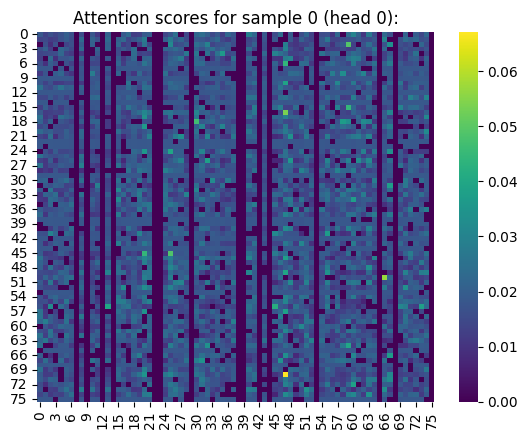

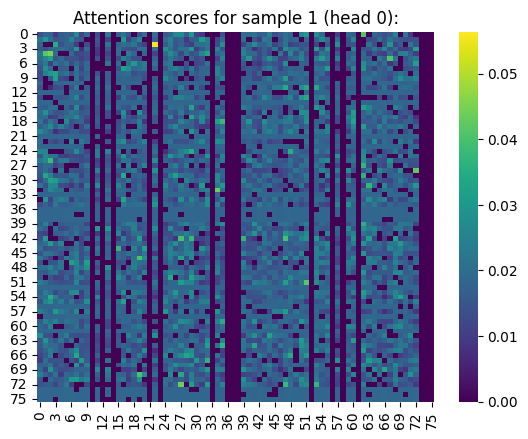

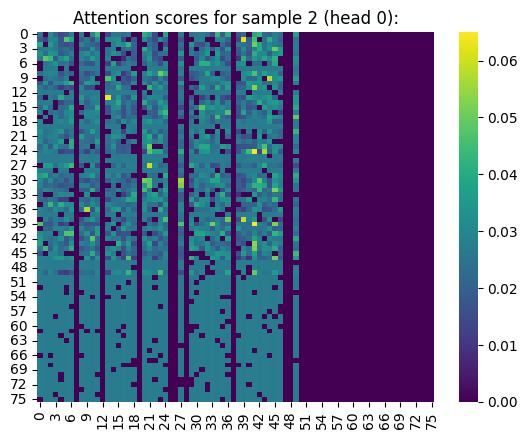

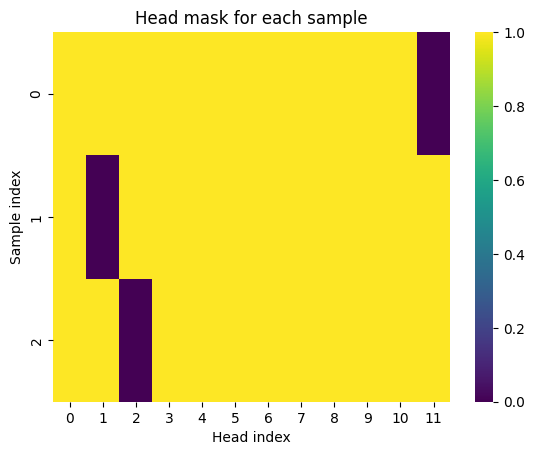

Layer 5 active tokens: tensor([55., 54., 37.])
Layer 5 active heads: tensor([10., 10., 10.])
tensor([55., 54., 37.])


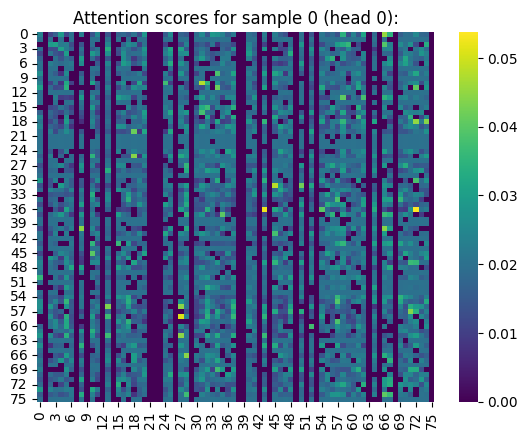

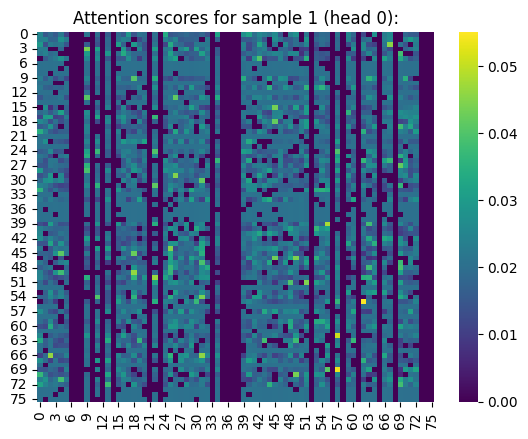

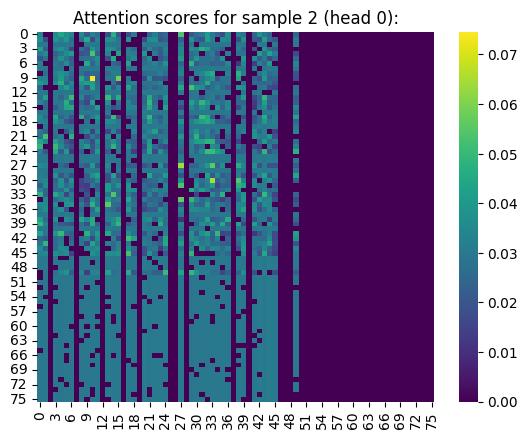

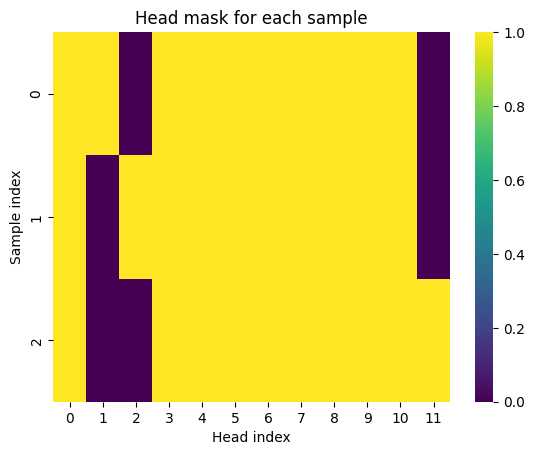

Layer 6 active tokens: tensor([55., 54., 37.])
Layer 6 active heads: tensor([10., 10., 10.])
tensor([55., 54., 37.])


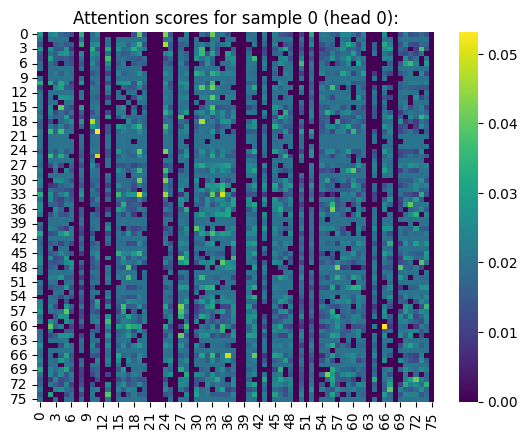

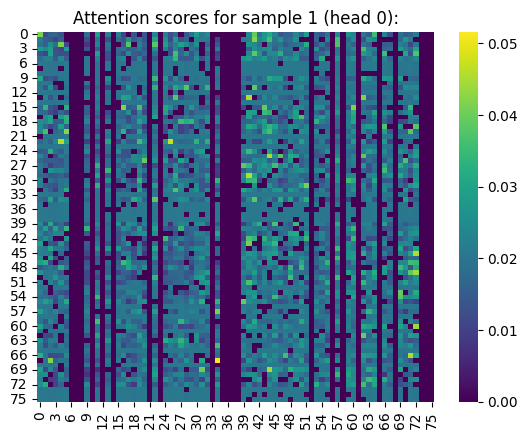

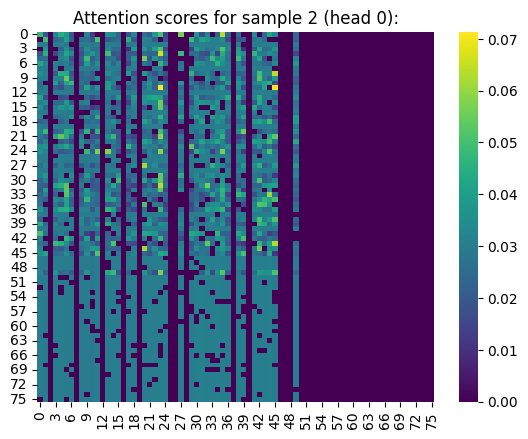

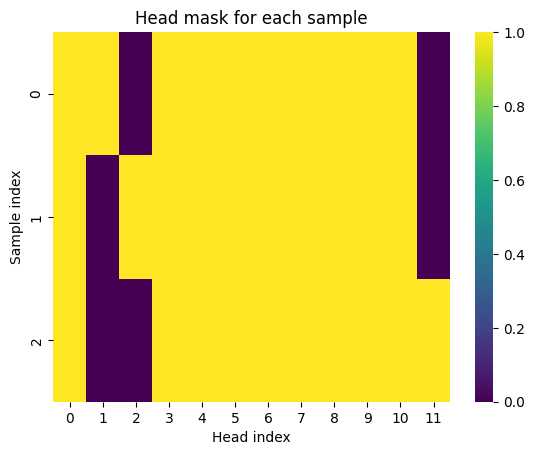

Layer 7 active tokens: tensor([49., 49., 33.])
Layer 7 active heads: tensor([10., 10., 10.])
tensor([49., 49., 33.])


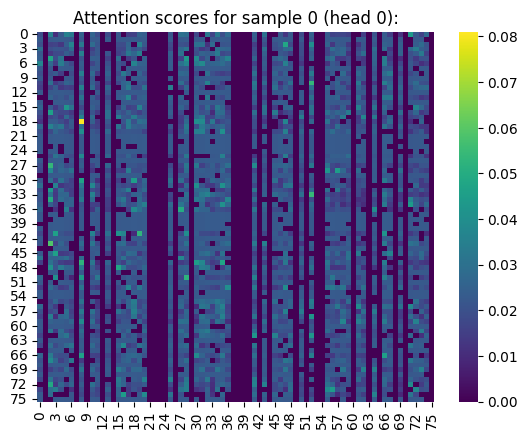

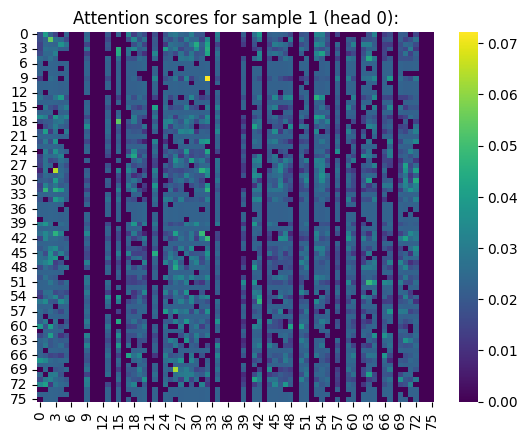

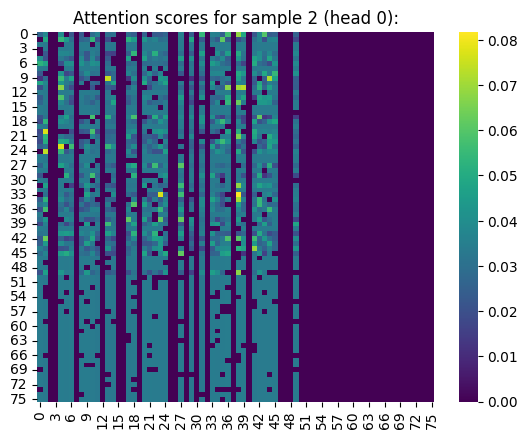

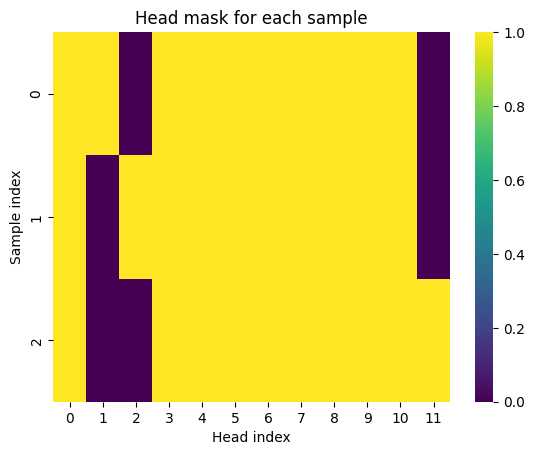

Layer 8 active tokens: tensor([49., 49., 33.])
Layer 8 active heads: tensor([10., 10., 10.])
tensor([49., 49., 33.])


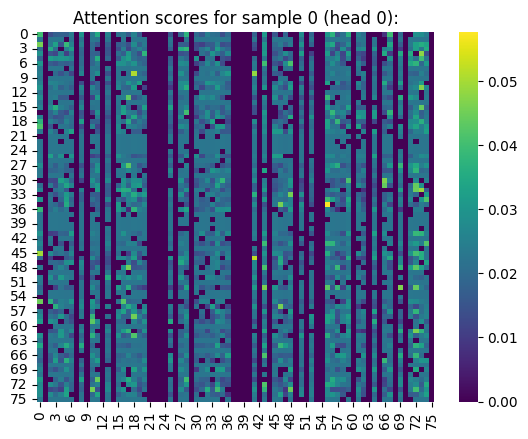

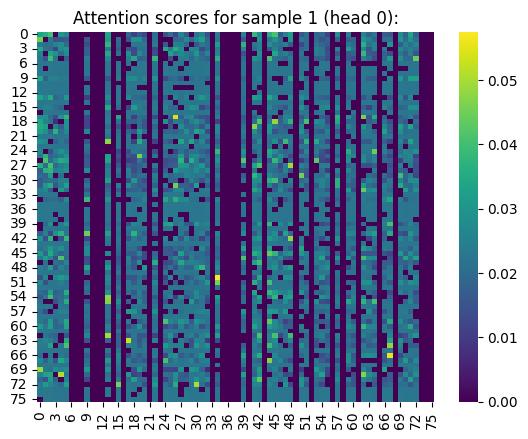

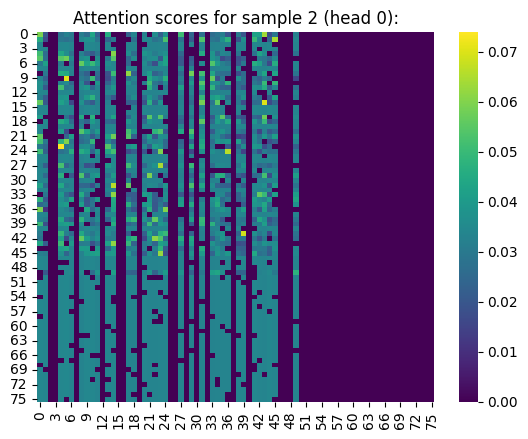

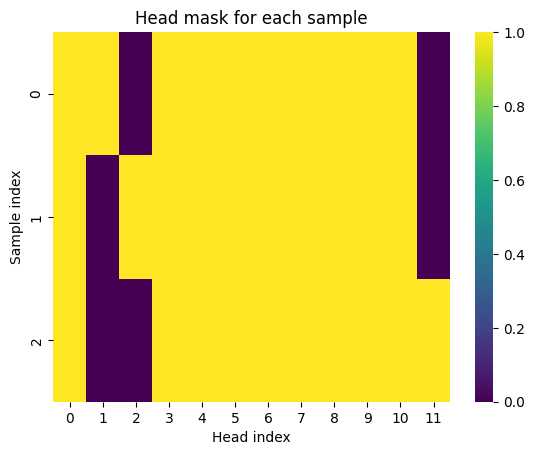

Layer 9 active tokens: tensor([44., 44., 30.])
Layer 9 active heads: tensor([10., 10., 10.])
tensor([44., 44., 30.])


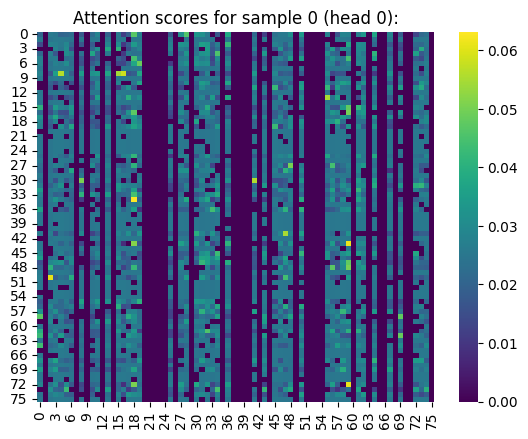

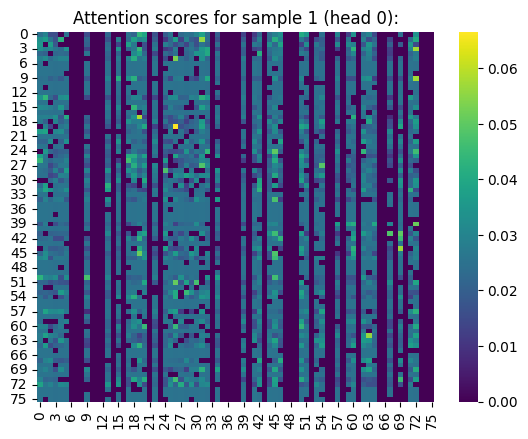

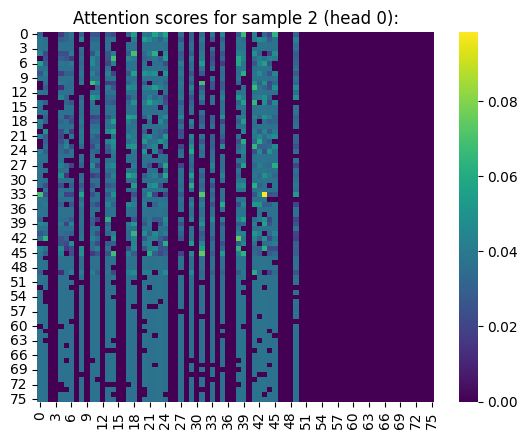

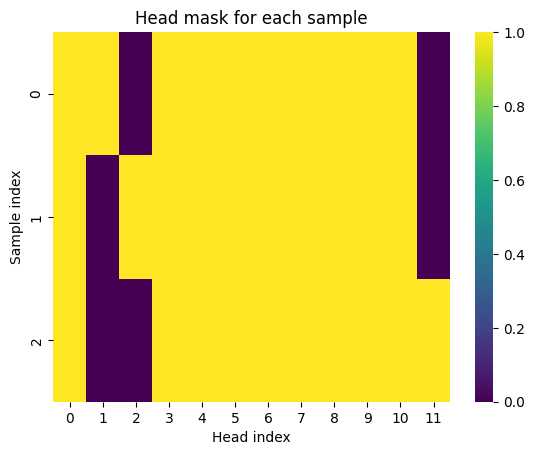

Layer 10 active tokens: tensor([44., 44., 30.])
Layer 10 active heads: tensor([10., 10., 10.])
tensor([44., 44., 30.])


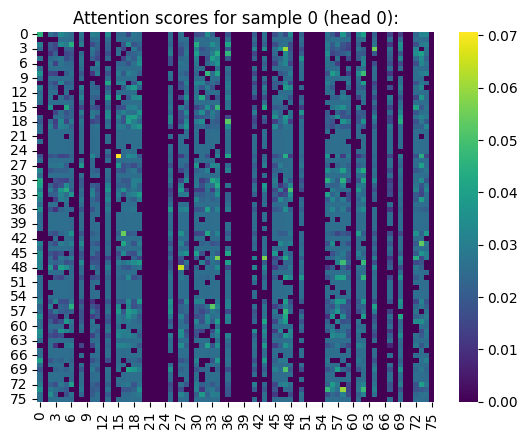

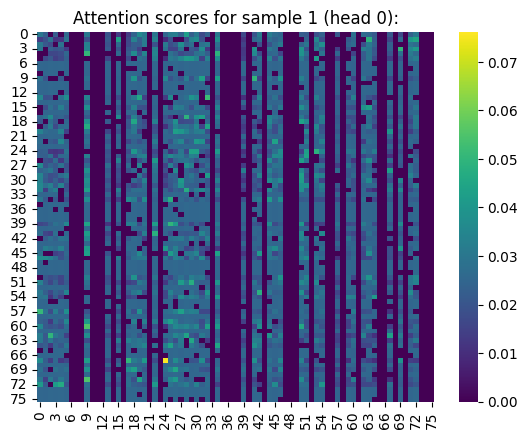

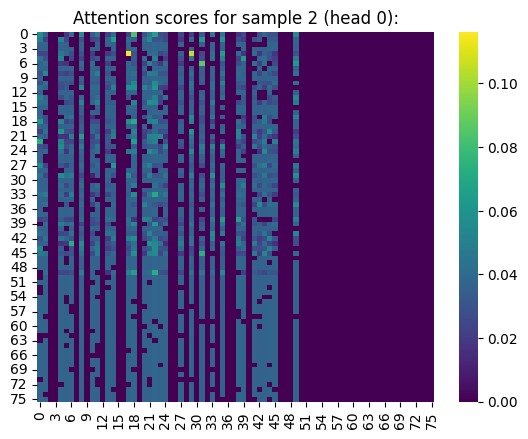

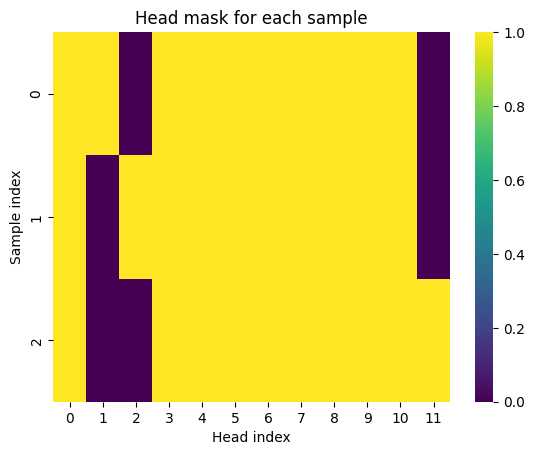

Layer 11 active tokens: tensor([40., 39., 27.])
Layer 11 active heads: tensor([9., 9., 9.])

Input used at layer 0:
['[CLS]', 'we', 'present', 'spat', '##ten', ',', 'an', 'efficient', 'algorithm', '-', 'architecture', 'co', '-', 'design', 'that', 'leverage', '##s', 'token', 'spa', '##rs', '##ity', ',', 'head', 'spa', '##rs', '##ity', ',', 'and', 'quan', '##ti', '##zation', 'opportunities', 'to', 'reduce', 'the', 'attention', 'computation', 'and', 'memory', 'access', '.', 'inspired', 'by', 'the', 'high', 'red', '##unda', '##ncy', 'of', 'human', 'languages', ',', 'we', 'propose', 'the', 'novel', 'kv', 'token', 'pr', '##uni', '##ng', 'to', 'pr', '##une', 'away', 'un', '##im', '##port', '##ant', 'token', '##s', 'in', 'the', 'sentence', '.', '[SEP]']
['[CLS]', 'to', 'efficiently', 'support', 'them', 'on', 'hardware', ',', 'we', 'design', 'a', 'novel', 'top', '-', 'k', 'engine', 'to', 'rank', 'token', 'and', 'head', 'importance', 'scores', 'with', 'high', 'through', '##put', '.', 'furthermor

In [51]:
bert_cfg = BertConfig.from_pretrained(CFG['model_name'])

bert_cfg.output_attentions = True
bert_cfg.output_hidden_states = False
bert_cfg.return_dict = True

pt_schedule = [0.1 for _ in range(bert_cfg.num_hidden_layers)]
for i in range(len(pt_schedule)):
    if i % 2 == 0:
        pt_schedule[i] = 0.0
pt_schedule[0] = 0.0  # No pruning in the first layer

ph_schedule = [0.03 for _ in range(bert_cfg.num_hidden_layers)]
for i in range(len(ph_schedule)):
    if i % 2 == 0:
        ph_schedule[i] = 0.0
ph_schedule[0] = 0.0  # No pruning in the first layer

def calculate_p_schedule(p_schedule):
    for i in range(len(p_schedule)):
        if i == 0:
            p_schedule[i] = 0.0
        else:
            p_schedule[i] = 1-(1-p_schedule[i-1])*(1-p_schedule[i])

    return p_schedule


bert_cfg.pt = calculate_p_schedule(pt_schedule)
print("Cascading token pruning schedule:", bert_cfg.pt)

bert_cfg.ph = calculate_p_schedule(ph_schedule)
print("Cascading head pruning schedule:", bert_cfg.ph)


model = MyClassifierSpAtten(
    config=bert_cfg,
    base_model_name=CFG['model_name'],
    num_labels=len(
        CFG['train_dataset_CFG']['classes'][CFG['train_dataset_CFG']['task']]
    ),
    visualize_prune_decisions=True
)

tokenizer = BertTokenizer.from_pretrained(CFG['model_name'])

texts = [
    "We present SpAtten, an efficient algorithm-architecture co-design that leverages token sparsity, head sparsity, and quantization opportunities to reduce the attention computation and memory access. Inspired by the high redundancy of human languages, we propose the novel KV token pruning to prune away unimportant tokens in the sentence.",
    "To efficiently support them on hardware, we design a novel top-k engine to rank token and head importance scores with high throughput. Furthermore, we propose progressive quantization that first fetches MSBs only and performs the computation; if the confidence is low, it fetches LSBs and recomputes the attention outputs, trading computation for memory reduction",
    " Inspired by the high redundancy of human languages, we propose the novel cascade token pruning to prune away unimportant tokens in the sentence. We also propose cascade head pruning to remove unessential heads."
]

inputs = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding=True,
    max_length=200,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

model(inputs)

# print(model.bert.encoder.text_history)
for layer_info in model.bert.encoder.text_history:
    layer = layer_info["layer"]
    token_mask = layer_info["active_tokens"]

    print(f"\nInput used at layer {layer}:")


    for j, text in enumerate(texts):
        # Select active token IDs
        active_token_ids = inputs["input_ids"][j][token_mask[j] == 1]

        # Convert IDs → tokens
        tokens = tokenizer.convert_ids_to_tokens(active_token_ids)

        print(tokens)



## Decoder

In [ ]:
class MyDecoder(torch.nn.Module):
    """
    Decoder model with LoRA and quantization for sentiment and/or sarcasm analysis.
    """
    def __init__(self, decoder_name, quantization_config, lora_config, task, device):
        super().__init__()

        self.quantization_config = quantization_config
        self.lora_config = lora_config
        self.task = task
        self.is_multitask = 'sentiment' in self.task.lower() and 'sarcasm' in self.task.lower()
        self.device = device

        self.decoder = transformers.AutoModelForCausalLM.from_pretrained(decoder_name, quantization_config=self.quantization_config, device_map=self.device)
        self.decoder = get_peft_model(self.decoder, self.lora_config)

        self.tokenizer = transformers.AutoTokenizer.from_pretrained(decoder_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        if self.is_multitask:
            #TODO: implement multitask prefill
            self.prefill = ""
        elif self.task.lower() == 'sentiment':
            self.prefill = """
Generate the sentiment of the given text.
1 for positive sentiment, and 0 for negative sentiment.
Do not give an explanation, just the number.
"""
        elif self.task.lower() == 'sarcasm':
            self.prefill = """
Predict if the given text is sarcastic.
1 if the text is sarcastic, and 0 if the text is not sarcastic.
Do not give an explanation, just the number."""
        else:
            raise ValueError(f"Unknown task: {self.task}")

    def label_to_str(self, label: torch.Tensor) -> str:
        """
        Applying direcly str(label) adds extra characters (like tensor(...)) that
        can confuse the decoder during training.
        """
        if not self.is_multitask:
            return str(label.item())
        else:
            return f"{label[0].item()},{label[1].item()}"

    def create_train_prompt(self, input):
        return [{
                "role": "user",
                "content": f"{self.prefill}\n{input['text']}"
            },
            {
                "role": "assistant",
                "content": f"{self.label_to_str(input['label'])}"
            }
        ]

    def create_infer_prompt(self, input):
        return [{
                "role": "user",
                "content": f"{self.prefill}\n{input['text']}"
            }
        ]

    # TODO: main problem is that loss is computed over all tokens, need to mask
    # so that only generated tokens of the task are considered in the loss calculation
    # @ChatGPT suggested assistant_token_id = self.tokenizer.convert_tokens_to_ids(self.tokenizer.special_tokens_map["bos_token"])
    # or simply to mask everything except last N tokens
    # TODO: how to handle batch size > 1? Or do we even need to do this?
    # NOTE: assume batch size of 1
    def forward(self, input):
        # message = self.create_train_prompt(input)
        message = [self.create_train_prompt(sample) for sample in input]

        # Add special tokens and tokenize
        input = self.tokenizer.apply_chat_template(
            message,
            return_tensors="pt",
            add_generation_prompt=False
        ).to(self.device)

        input_ids = input["input_ids"]      # (B, T)
        attention_mask = input["attention_mask"]        # (B, T)

        #TODO: check if label is correctly set
        labels = torch.full_like(input_ids, fill_value=-100)        # (B, T)
        for i in range(input_ids.size(0)):
            last_token_idx = attention_mask[i].sum() - 1
            labels[i, last_token_idx] = input_ids[i, last_token_idx]

        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        return outputs

    def infer(self, input):
        messages = self.create_infer_prompt(input)

        input = self.tokenizer.apply_chat_template(
            messages,
            return_tensors="pt",
            add_generation_prompt=True
        ).to(self.device)

        output_ids = self.decoder.generate(
            input_ids=input['input_ids'],
            attention_mask=input['attention_mask'],
            max_new_tokens=3 if self.is_multitask else 1, #TODO: check if enough/correct
            do_sample=False
        )

        # TODO: check if extracted last token generated
        prediction = self.tokenizer.decode(
            output_ids[0][input["input_ids"].shape[1]:],
            skip_special_tokens=True
        ).strip()

        return prediction

    def get_tokenizer(self) -> transformers.PreTrainedTokenizer:
        return self.tokenizer

In [ ]:
decoder_name = "mistralai/Mistral-7B-Instruct-v0.3"

# decoder = MyDecoder(
#     decoder_name=decoder_name,
#     quantization_config=quantization_config,
#     lora_config=lora_config,
#     task=CFG['train_dataset_CFG']['task'],
#     device=device
# )

# tokenizer = decoder.get_tokenizer()

# Train

## Multitask

In [ ]:
def train_SS(model, train_loader, optimizer, criterion, device):
    model.train()

    train_sarc_loss = 0.0
    train_sent_loss = 0.0
    train_sarc_acc = 0.0
    train_sent_acc = 0.0
    c1, c2 = criterion

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].to(device)
        outputs = model(inputs)

        sent_loss = c1(outputs['sentiment'], local_labels[:,0])
        sarc_loss = c2(outputs['sarcasm'], local_labels[:,1])

        loss = sarc_loss + sent_loss
        loss.backward()
        # optimizer.pc_backward([sarc_loss, sent_loss])
        optimizer.step()
        optimizer.zero_grad()

        train_sarc_loss += sarc_loss.item()
        train_sent_loss += sent_loss.item()

        _, preds_sarc = torch.max(outputs['sarcasm'], dim=1)
        _, preds_sent = torch.max(outputs['sentiment'], dim=1)
        train_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()
        train_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()

    return train_sarc_loss / len(train_loader), train_sent_loss / len(train_loader), train_sarc_acc / (len(train_loader.dataset)), train_sent_acc / (len(train_loader.dataset))


In [ ]:
def train_spAtten(model, train_loader, optimizer, criterion, device):
    model.train()

    train_sarc_loss = 0.0
    train_sent_loss = 0.0
    train_sarc_acc = 0.0
    train_sent_acc = 0.0
    c1, c2 = criterion

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].to(device)
        outputs = model(inputs)

        sent_loss = c1(outputs[:,:3], local_labels[:,0])
        sarc_loss = c2(outputs[:,3:], local_labels[:,1])

        loss = sarc_loss + sent_loss
        loss.backward()
        # optimizer.pc_backward([sarc_loss, sent_loss])
        optimizer.step()
        optimizer.zero_grad()

        train_sarc_loss += sarc_loss.item()
        train_sent_loss += sent_loss.item()

        _, preds_sarc = torch.max(outputs[:,:3], dim=1)
        _, preds_sent = torch.max(outputs[:,3:], dim=1)
        train_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()
        train_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()

    return train_sarc_loss / len(train_loader), train_sent_loss / len(train_loader), train_sarc_acc / (len(train_loader.dataset)), train_sent_acc / (len(train_loader.dataset))


## Singletask

In [ ]:
def train(model, task, train_loader, optimizer, criterion, device):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].flatten().to(device)
        outputs = model(inputs, task=task)

        loss = criterion(outputs, local_labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        train_acc += torch.sum(preds == local_labels).item()

    return train_loss / len(train_loader), train_acc / (len(train_loader.dataset))

In [ ]:
def train_decoder(model, task, train_loader, optimizer, device):
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        local_labels = batch['label'].flatten().to(device)
        outputs = model(inputs, task=task)

        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        # TODO: check accuracy calculation for decoder
        # other solution by ChatGPT
        # preds = model.infer(batch)  # "0" o "1"
        # train_acc += int(preds == local_labels)
        _, preds = torch.max(outputs, dim=1)
        train_acc += torch.sum(preds == local_labels).item()

    return train_loss / len(train_loader), train_acc / (len(train_loader.dataset))

# Validation

## Multitask

In [ ]:
from sklearn.metrics import f1_score

def validate_SS(model, val_loader, criterion, device):
    model.eval()
    val_sarc_acc = 0.0
    val_sent_acc = 0.0
    val_sarc_loss = 0.0
    val_sent_loss = 0.
    all_sent_preds = []
    all_sent_labels = []
    all_sarc_preds = []
    all_sarc_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].to(device)
            outputs = model(inputs)

            sentiment_criterion, sarcasm_criterion = criterion
            sarc_loss = sarcasm_criterion(outputs['sarcasm'], local_labels[:,1])
            sent_loss = sentiment_criterion(outputs['sentiment'], local_labels[:,0])

            _, preds_sarc = torch.max(outputs['sarcasm'], dim=1)
            _, preds_sent = torch.max(outputs['sentiment'], dim=1)

            val_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()
            val_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()

            val_sarc_loss += sarc_loss.item()
            val_sent_loss += sent_loss.item()

            all_sent_preds.extend(preds_sent.cpu().numpy())
            all_sent_labels.extend(local_labels[:,0].cpu().numpy())
            all_sarc_preds.extend(preds_sarc.cpu().numpy())
            all_sarc_labels.extend(local_labels[:,1].cpu().numpy())


    f1_sent = f1_score(all_sent_labels, all_sent_preds, average='weighted')
    f1_sarc = f1_score(all_sarc_labels, all_sarc_preds, average='weighted')
    return val_sarc_loss / len(val_loader), val_sarc_acc / len(val_loader.dataset), val_sent_loss / len(val_loader), val_sent_acc / len(val_loader.dataset), f1_sarc, f1_sent

In [ ]:
def validate_spAtten(model, val_loader, criterion, device):
    model.eval()
    val_sarc_acc = 0.0
    val_sent_acc = 0.0
    val_sarc_loss = 0.0
    val_sent_loss = 0.
    all_sent_preds = []
    all_sent_labels = []
    all_sarc_preds = []
    all_sarc_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].to(device)
            outputs = model(inputs)

            sentiment_criterion, sarcasm_criterion = criterion
            sarc_loss = sarcasm_criterion(outputs[:,3:], local_labels[:,1])
            sent_loss = sentiment_criterion(outputs[:,:3], local_labels[:,0])

            _, preds_sarc = torch.max(outputs[:,3:], dim=1)
            _, preds_sent = torch.max(outputs[:,:3], dim=1)

            val_sent_acc += torch.sum(preds_sent == local_labels[:,0]).item()
            val_sarc_acc += torch.sum(preds_sarc == local_labels[:,1]).item()

            val_sarc_loss += sarc_loss.item()
            val_sent_loss += sent_loss.item()

            all_sent_preds.extend(preds_sent.cpu().numpy())
            all_sent_labels.extend(local_labels[:,0].cpu().numpy())
            all_sarc_preds.extend(preds_sarc.cpu().numpy())
            all_sarc_labels.extend(local_labels[:,1].cpu().numpy())


    f1_sent = f1_score(all_sent_labels, all_sent_preds, average='weighted')
    f1_sarc = f1_score(all_sarc_labels, all_sarc_preds, average='weighted')
    return val_sarc_loss / len(val_loader), val_sarc_acc / len(val_loader.dataset), val_sent_loss / len(val_loader), val_sent_acc / len(val_loader.dataset), f1_sarc, f1_sent

## Singletask

In [ ]:
def validate(model, task, val_loader, criterion, device):
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            local_labels = batch['label'].flatten().to(device)
            outputs = model(inputs, task=task)

            loss = criterion(outputs, local_labels)
            _, preds = torch.max(outputs, dim=1)
            val_acc += torch.sum(preds == local_labels).item()
            val_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(local_labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss / len(val_loader), val_acc / len(val_loader.dataset), f1

# Wandb

In [ ]:
if CFG['train_dataset_CFG'].get('variety', None) == None:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['task']}_spatten"
else:
    run_id = f"{CFG['model_name']}_{CFG['classification_head']}_{CFG['train_dataset_CFG']['dataset_name']}_{CFG['train_dataset_CFG']['variety']}_{CFG['train_dataset_CFG']['task']}"
if ENABLE_WANDB:
    import wandb
    # NOTE: set run_name
    # run_id = None

    run = wandb.init(
        entity="elena-nespolo02-politecnico-di-torino",
        project="Figurative Analysis",
        name=run_name,
        id=run_id,
        resume="allow",
        config=CFG,
        tags=[CFG['train_dataset_CFG']['dataset_name'], CFG['train_dataset_CFG']['task'], CFG['model_name']]
    )

    wandb.define_metric("epoch/step")
    wandb.define_metric("epoch/*", step_metric="epoch/step")

    wandb.define_metric("train/step")
    wandb.define_metric("train/*", step_metric="train/step")

    wandb.define_metric("validate/step")
    wandb.define_metric("validate/*", step_metric="validate/step")



# ML pipeline

In [ ]:
models_root_dir = "./models"
os.makedirs(models_root_dir, exist_ok=True)

model_name = CFG['model_name']
tokenizer, model = get_tokenizer_and_encoder(model_name)

tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

# setup classifier model
if use_spAtten:
    model = MyClassifierSpAtten(
        config=bert_cfg,
        base_model_name=CFG['model_name'],
        num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
        visualize_prune_decisions=True
    ).to(device)
else:
    model = MyClassifier(
        base_model_name=model_name,
        classification_head_name=CFG['classification_head'],
        num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
        multitask=IS_MULTITASK
    ).to(device)

print(model)
train_ds = get_dataset(
    CFG['train_dataset_CFG'],
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)
val_ds = get_dataset(
    CFG['valid_dataset_CFG'],
    minlength=CFG['min_length'],
    maxlength=CFG['max_length'],
    tokenizer=tokenizer,
)

print("Training dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))

labels_count = {}
for t, cs in train_ds.get_label_count().items():
    if t in CFG['train_dataset_CFG']['task'].lower():
        labels_count[t] = [c for c in cs.values()]
print(labels_count)

if IS_MULTITASK:
    optimizer = PCGrad(torch.optim.Adam(model.parameters(), lr=CFG['lr']))
    sarc_weights = labels_count['sarcasm']
    sent_weights = labels_count['sentiment']
    sum_sarc = sum(sarc_weights)
    sum_sent = sum(sent_weights)
    sarcasm_criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([sw/sum_sarc for sw in sarc_weights], dtype=torch.float).to(device)
    )
    sentiment_criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([sw/sum_sent for sw in sent_weights], dtype=torch.float).to(device)
    )
    criterion = [sentiment_criterion, sarcasm_criterion] # a list of per-task losses
    print([
        x.weight for x in criterion
    ])
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
    weights = labels_count[list(labels_count.keys())[0]]
    criterion = torch.nn.CrossEntropyLoss(
        weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
    )

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=CFG['batch_size'],
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=CFG['batch_size'],
    shuffle=False
)

# Loading form a starting point
if CFG['start_epoch'] > 0 and ENABLE_WANDB:
    artifact = run.use_artifact(f'elena-nespolo02-politecnico-di-torino/Figurative Analysis/{run_id}:epoch_{CFG['start_epoch']}', type='model')
    artifact_dir = artifact.download()

    artifact_path = os.path.join(artifact_dir, run_id+f"_epoch_{CFG['start_epoch']}.pth")

    checkpoint = torch.load(artifact_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    if not IS_MULTITASK:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    else:
        optimizer.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

MyClassifierSpAtten(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CascadingBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CascadingMaskBertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [ ]:
sample = next(iter(train_loader))
print(sample['attention_mask'][0].sum())
inputs = {
    'input_ids': sample['input_ids'].to(device),
    'attention_mask': sample['attention_mask'].to(device)
}
model(inputs, task=CFG['train_dataset_CFG']['task'])

tensor(65)
Layer 0 active tokens: tensor([200., 200., 200., 200., 200., 200., 200., 200.], device='cuda:0')
Layer 0 active heads: tensor([12., 12., 12., 12., 12., 12., 12., 12.], device='cuda:0')
Layer 1 active tokens: tensor([186., 186., 186., 186., 186., 186., 186., 186.], device='cuda:0')
Layer 1 active heads: tensor([11., 11., 11., 11., 11., 11., 11., 11.], device='cuda:0')
Layer 2 active tokens: tensor([186., 186., 186., 186., 186., 186., 186., 186.], device='cuda:0')
Layer 2 active heads: tensor([11., 11., 11., 11., 11., 11., 11., 11.], device='cuda:0')
Layer 3 active tokens: tensor([172., 172., 172., 172., 172., 172., 172., 172.], device='cuda:0')
Layer 3 active heads: tensor([11., 11., 11., 11., 11., 11., 11., 11.], device='cuda:0')
Layer 4 active tokens: tensor([172., 172., 172., 172., 172., 172., 172., 172.], device='cuda:0')
Layer 4 active heads: tensor([11., 11., 11., 11., 11., 11., 11., 11.], device='cuda:0')
Layer 5 active tokens: tensor([160., 160., 160., 160., 160., 160

tensor([[ 0.0745,  0.4634],
        [ 0.1588,  0.7816],
        [ 0.2558,  0.7227],
        [ 0.4719,  0.9088],
        [ 0.6199,  1.2601],
        [-0.2118,  0.6099],
        [ 0.3358,  0.8285],
        [ 0.3691,  1.4046]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Main Loop

In [ ]:
for epoch in range(CFG['start_epoch']+1,CFG['epochs']+1):
    print(f"Epoch {epoch}/{CFG['epochs']}")

    if IS_MULTITASK:
        if use_spAtten:
            epoch_sarc_loss, epoch_sent_loss, epoch_sarc_acc, epoch_sent_acc = train_spAtten(model, train_loader, optimizer, criterion, device)

            val_sarc_loss, val_sarc_acc, val_sent_loss, val_sent_acc, f1_sarc, f1_sent = validate_spAtten(model, val_loader, criterion, device)
        else:
            epoch_sarc_loss, epoch_sent_loss, epoch_sarc_acc, epoch_sent_acc = train_SS(model, train_loader, optimizer, criterion, device)

            val_sarc_loss, val_sarc_acc, val_sent_loss, val_sent_acc, f1_sarc, f1_sent = validate_SS(model, val_loader, criterion, device)

        if ENABLE_WANDB:
            run.log({
                    "epoch/step": epoch,
                    "epoch/train_sarc_loss": epoch_sarc_loss,
                    "epoch/train_sent_loss": epoch_sent_loss,
                    "epoch/train_sarc_acc": epoch_sarc_acc,
                    "epoch/train_sent_acc": epoch_sent_acc,
                    "epoch/val_sarc_loss": val_sarc_loss,
                    "epoch/val_sent_loss": val_sent_loss,
                    "epoch/val_sarc_acc": val_sarc_acc,
                    "epoch/val_sent_acc": val_sent_acc
                },
                commit=True,
            )
        print(f"Training Sarcasm Loss: {epoch_sarc_loss:.4f}")
        print(f"Training Sentiment Loss: {epoch_sent_loss:.4f}")
        print(f"Training Sarcasm Acc: {epoch_sarc_acc:.4f}")
        print(f"Training Sentiment Acc: {epoch_sent_acc:.4f}")
        print(f"Validation Sarcasm Loss: {val_sarc_loss:.4f}")
        print(f"Validation Sentiment Loss: {val_sent_loss:.4f}")
        print(f"Validation Sarcasm Acc: {val_sarc_acc:.4f}")
        print(f"Validation Sentiment Acc: {val_sent_acc:.4f}")

    else:
        epoch_loss, epoch_acc = train(model, CFG['train_dataset_CFG']['task'], train_loader, optimizer, criterion, device)

        val_loss, val_acc, val_f1 = validate(model, CFG['valid_dataset_CFG']['task'], val_loader, criterion, device)

        if ENABLE_WANDB:
            run.log({
                    "epoch/step": epoch,
                    "epoch/train_loss": epoch_loss,
                    "epoch/train_acc": epoch_acc,
                    "epoch/val_loss": val_loss,
                    "epoch/val_acc": val_acc,
                    "epoch/val_f1": val_f1
                },
                commit=True,
            )

        print(f"Training Loss: {epoch_loss:.4f}")
        print(f"Training Acc: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Acc: {val_acc:.4f}")

    if (epoch % 30) == 0 or (epoch == CFG['epochs']):
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.optimizer.state_dict() if IS_MULTITASK else optimizer.state_dict(),
            "epoch/step": epoch
        }

        file_name = f"{run_id}_epoch_{epoch}.pth"

        # Saving the progress
        file_path = os.path.join(models_root_dir, file_name)
        torch.save(checkpoint, file_path)

        print(f"Model saved to {file_path}")

        if ENABLE_WANDB:
            artifact = wandb.Artifact(name=run_id, type="model")
            artifact.add_file(file_path)

            run.log_artifact(artifact, aliases=["latest", f"epoch_{epoch}"])

if ENABLE_WANDB:
    run.finish()

In [ ]:
if ENABLE_WANDB:
    run.finish()

# Testing

## Load a model

In [ ]:
def get_model(CFG, run_id, epoch, is_multitask, device):
    model = MyClassifier(
        base_model_name=CFG['model_name'],
        classification_head_name=CFG['classification_head'],
        num_labels=[len(v) if k in CFG['train_dataset_CFG']['task'].lower() else 0 for k,v in CFG['train_dataset_CFG']['classes'].items()],
        multitask=is_multitask
    ).to(device)

    if not os.path.exists(models_root_dir):
        artifact = run.use_artifact(f'elena-nespolo02-politecnico-di-torino/Figurative Analysis/{run_id}:epoch_{epoch}', type='model')
        artifact_dir = artifact.download()

        artifact_path = os.path.join(artifact_dir, run_id+f"_epoch_{epoch}.pth")

        checkpoint = torch.load(artifact_path, map_location=device)

    else:
        file_name = f"{run_id}_epoch_{epoch}.pth"
        model_path = os.path.join(models_root_dir, file_name)

        checkpoint = torch.load(model_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model

## For each variety

In [ ]:
results = {}

# Loading the trained model
test_model = get_model(CFG, run_id, 30, IS_MULTITASK, device)

for variety in ['en-AU', 'en-IN', 'en-UK']:
    print(f"Testing on variety: {variety}")
    for source, task in [('Reddit', 'sentiment'), ('Google', 'sentiment'), ('Reddit', 'sarcasm')]:
        if task not in CFG['valid_dataset_CFG']['task'].lower():
            continue

        print(f"\tTesting on {source} for task: {task}")

        dataset_CFG = CFG['valid_dataset_CFG'].copy()
        dataset_CFG['variety'] = variety
        dataset_CFG['source'] = source
        dataset_CFG['task'] = task

        from dataset.besstie import dataset_besstie

        tokenizer = model.get_tokenizer()
        test_ds = dataset_besstie.BesstieDataSet(
            **dataset_CFG,
            tokenizer=tokenizer,
            min_length=1,
            max_length=200,
        )

        test_loader = torch.utils.data.DataLoader(
            test_ds,
            batch_size=CFG['batch_size'],
            shuffle=False
        )
        print(f"\t\tTest dataset size: {len(test_ds)}")
        if IS_MULTITASK:
            optimizer = PCGrad(torch.optim.Adam(model.parameters(), lr=CFG['lr']))
            sarc_weights = labels_count['sarcasm']
            sent_weights = labels_count['sentiment']
            sum_sarc = sum(sarc_weights)
            sum_sent = sum(sent_weights)
            sarcasm_criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_sarc for sw in sarc_weights], dtype=torch.float).to(device)
            )
            sentiment_criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([sw/sum_sent for sw in sent_weights], dtype=torch.float).to(device)
            )
            criterion = [sarcasm_criterion, sentiment_criterion] # a list of per-task losses

            test_sarc_loss, test_sarc_acc, test_sarc_f1 = validate(test_model, 'sarcasm', test_loader, sarcasm_criterion, device)
            test_sent_loss, test_sent_acc, test_sent_f1 = validate(test_model, 'sentiment', test_loader, sentiment_criterion, device)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
            weights = labels_count[list(labels_count.keys())[0]]
            criterion = torch.nn.CrossEntropyLoss(
                weight=torch.tensor([w/sum(weights) for w in weights], dtype=torch.float).to(device)
            )

            test_loss, test_acc, test_f1 = validate(test_model, task, test_loader, criterion, device)

        results[(variety, source)] = {
            'loss': test_loss if not IS_MULTITASK else (test_sent_loss, test_sarc_loss),
            'acc': test_acc if not IS_MULTITASK else (test_sent_acc, test_sarc_acc),
            'f1': test_f1 if not IS_MULTITASK else (test_sent_f1, test_sarc_f1)
        }


In [ ]:
print("Final Results")
import seaborn as sns

if not IS_MULTITASK:
    plt.figure()
    sns.heatmap(
        np.array([v['f1'] for v in results.values()]).reshape(3,2),
        annot=True,
        xticklabels=['Reddit', 'Google'],
        yticklabels=['en-AU', 'en-IN', 'en-UK'],
        cmap='Blues'
    )
    plt.title('F1 Score Heatmap')
else:
    for i,task in enumerate(['sentiment', 'sarcasm']):
        plt.figure()
        data = np.array([v['f1'][i] for v in results.values()]).reshape(3,2)
        sns.heatmap(
            data,
            annot=True,
            xticklabels=['Reddit', 'Google'],
            yticklabels=['en-AU', 'en-IN', 'en-UK'],
            cmap='Blues'
        )
        plt.title(f'F1 Score Heatmap - {task.capitalize()}')